In [1]:
import pandas as pd
import ir_datasets as irds
from ir_measures import read_trec_qrels
from ir_measures import * 
from ir_measures import evaluator
import pyterrier as pt
from scipy.stats import ttest_ind
import os
from os import path as path
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Data Ingestion

In [2]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [3]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [4]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

andrew-parry-qrels.txt
ferdinand-schlatt-qrels.txt
froebe-qrels.txt
guglielmo-faggioli-qrels.txt
harry-scells-qrels.txt
saber-zerhoudi-qrels.txt
sean-macavaney-qrels.txt
eugene-yang-qrels.txt


In [5]:
group_id_map ={
    'froebe' : 1,
    'ferdinand-schlatt' : 1,
    'andrew-parry' : 2,
    'eugene-yang' : 2,
    'guglielmo-faggioli' : 3,
    'harry-scells' : 3,
    'saber-zerhoudi' : 4,
    'sean-macavaney' : 4
}
all_qrels['group'] = all_qrels['annotator'].map(group_id_map)

In [6]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [7]:
RUN_DIR = f'{DIR}/runs/trec-dl-2019'
BM25_TUNED = 'dl-19-official-input.bm25tuned_p.gz'
BM25_BASE = 'dl-19-official-input.bm25base_p.gz'
SET_ENCODER_COLBERT = 'colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run'
COLBERT = 'maik-froebe-colbert-run.txt'
SPLADE = 'maik-froebe-splade-run.txt'
RANK_ZEPHYR = 'maik-froebe-rank-zephyr-run.txt'

In [8]:
BM25_TUNED_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_TUNED)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
BM25_BASE_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_BASE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SET_ENCODER_COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, SET_ENCODER_COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SPLADE_RUN = pt.io.read_results(path.join(RUN_DIR, SPLADE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
RANK_ZEPHYR_RUN = pt.io.read_results(path.join(RUN_DIR, RANK_ZEPHYR)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})

runs = {
    'bm25_tuned': BM25_TUNED_RUN,
    'bm25_base': BM25_BASE_RUN,
    'set_encoder_colbert': SET_ENCODER_COLBERT_RUN,
    'colbert': COLBERT_RUN,
    'splade': SPLADE_RUN,
    'rank_zephyr': RANK_ZEPHYR_RUN
}

In [9]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

In [10]:
original_evaluator = evaluator(metrics, qrels=original_qrels)

## Delta in Relevance Judgements

In [11]:
original_lookup = defaultdict(dict)

In [12]:
for row in original_qrels.itertuples():
    original_lookup[row.query_id][row.doc_id] = row.relevance

In [13]:
all_qrels['original_judgement'] = all_qrels.apply(lambda x : original_lookup[x.query_id][x.doc_id], axis=1)

In [14]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement
0,855410,8651770,2,0,andrew-parry,2,2
1,855410,8651771,2,0,andrew-parry,2,2
2,855410,8651772,1,0,andrew-parry,2,1
3,855410,8651775,3,0,andrew-parry,2,2
4,146187,1230566,1,0,andrew-parry,2,1
...,...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,2,0
1111,168216,4713638,0,0,eugene-yang,2,0
1112,168216,1696466,0,0,eugene-yang,2,0
1113,168216,4245224,0,0,eugene-yang,2,0


In [15]:
all_qrels.relevance.value_counts()

relevance
0    4103
1    2222
2    1809
3     870
Name: count, dtype: int64

In [16]:
all_qrels.original_judgement.value_counts()

original_judgement
2    3608
1    3202
3    1394
0     800
Name: count, dtype: int64

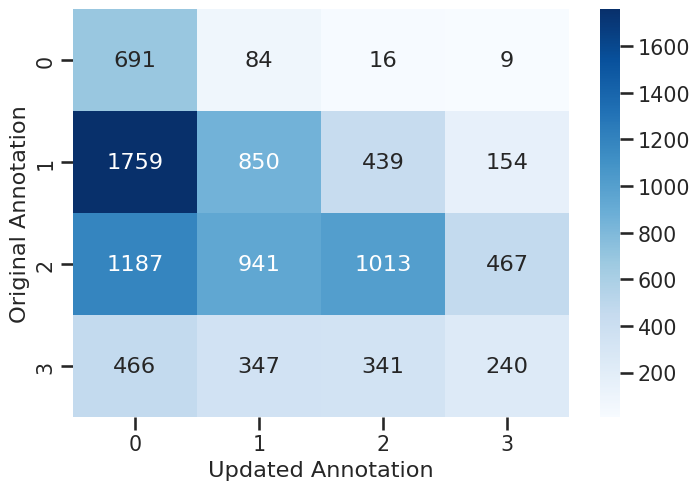

In [17]:
# Create a cross-tab (transition matrix) between original and updated relevance grades
sns.set_context("talk", font_scale=0.9)
sns.set_style("ticks")
transition_matrix = pd.crosstab(all_qrels['original_judgement'], all_qrels['relevance'])

# Plotting the transition matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d')
plt.subplots_adjust(bottom=0.2) 
plt.xlabel('Updated Annotation')
plt.ylabel('Original Annotation')
plt.savefig('plots/grade_transition.svg', format='svg')
plt.show()

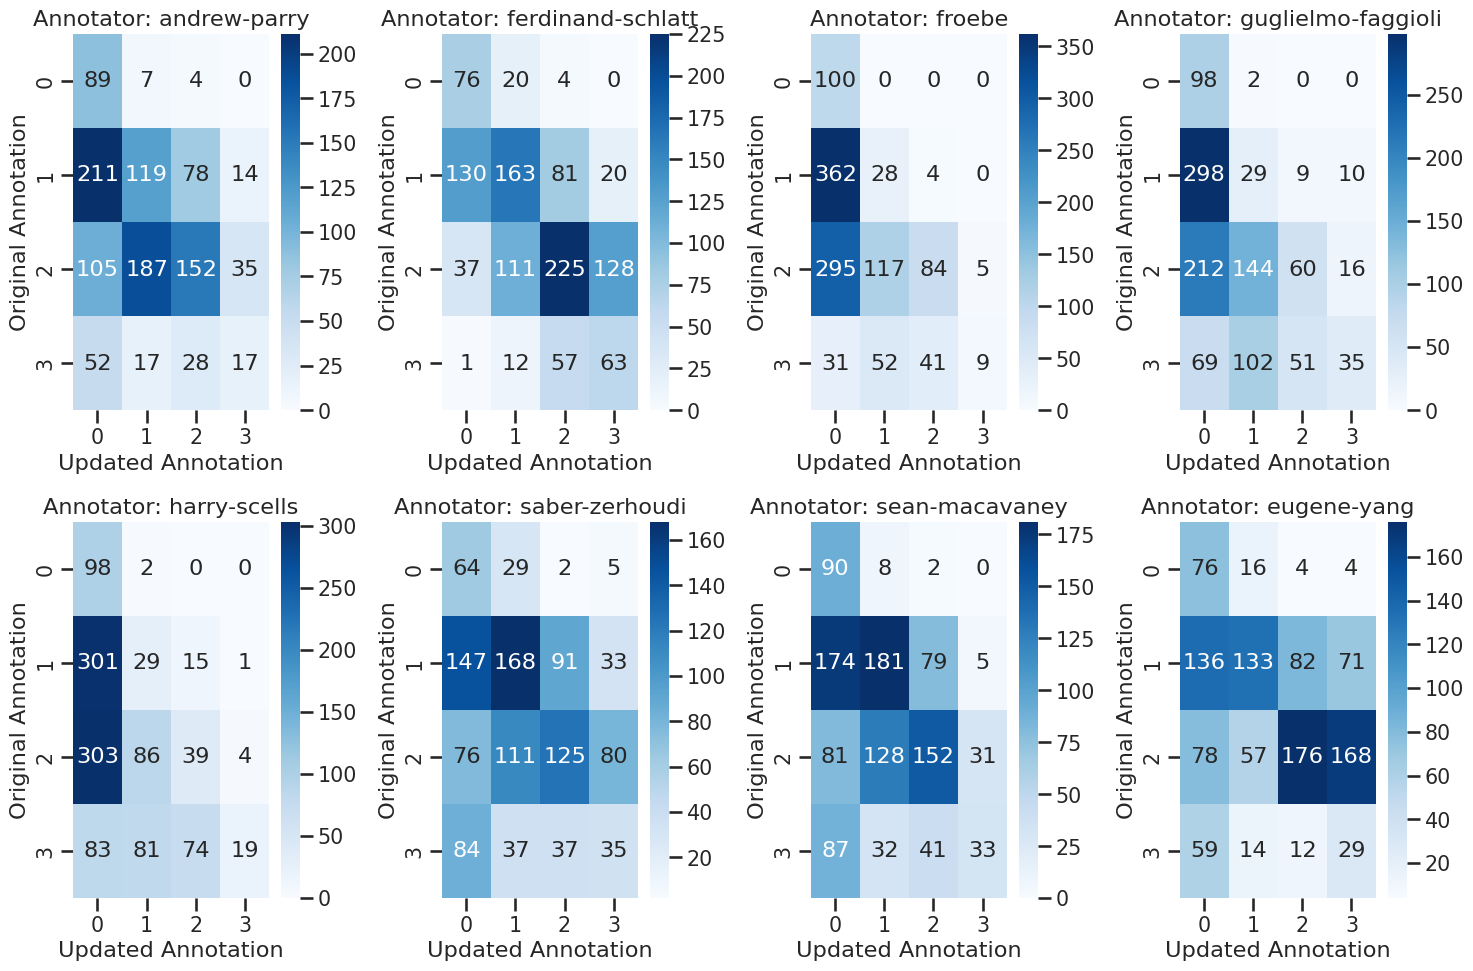

In [18]:

# Get unique annotators
annotators = all_qrels['annotator'].unique()

# Determine the number of rows and columns for the grid
n_annotators = len(annotators)
n_cols = 4  # Set to 3 or any number you prefer
n_rows = math.ceil(n_annotators / n_cols)

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten axes in case we have multiple rows and columns
axes = axes.flatten()

# Plot each annotator's transition matrix in a separate subplot
for i, annotator in enumerate(annotators):
    # Filter the dataframe for the current annotator
    df_annotator = all_qrels[all_qrels['annotator'] == annotator]

    # Create the transition matrix for the current annotator
    transition_matrix = pd.crosstab(df_annotator['original_judgement'], df_annotator['relevance'])

    # Plot the transition matrix
    sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[i])

    # Set titles and labels
    axes[i].set_title(f'Annotator: {annotator}')
    axes[i].set_xlabel('Updated Annotation')
    axes[i].set_ylabel('Original Annotation')

# Hide any unused subplots (if annotators don't fill the grid)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Agreement

In [22]:
from statsmodels.stats.inter_rater import fleiss_kappa

kappa_scores = {}

# Group by query_id and group_id
for (query_id, group_id), group in all_qrels.groupby(['query_id', 'group']):
    
    # Filter to ensure all doc_ids have at least 2 rows (annotations)
    doc_counts = group['doc_id'].value_counts()
    eligible_docs = doc_counts[doc_counts >= 2].index
    
    filtered_group = group[group['doc_id'].isin(eligible_docs)]
    
    # Create a contingency table for the relevance scores
    if not filtered_group.empty:
        crosstab = pd.crosstab(index=filtered_group['doc_id'], columns=filtered_group['relevance'])
        
        # Calculate Fleiss' Kappa
        if crosstab.sum().sum() > 0:  # Ensure there are ratings
            kappa_score = fleiss_kappa(crosstab)
            kappa_scores[(query_id, group_id)] = kappa_score

mean_kappa = {}
for (query_id, group_id), score in kappa_scores.items():
    if group_id not in mean_kappa:
        mean_kappa[group_id] = []
    mean_kappa[group_id].append(score)

# Compute the average Kappa scores for each group
for group_id, scores in mean_kappa.items():
    average_score = sum(scores) / len(scores) if scores else 0
    print(f"Mean Fleiss' Kappa for group {group_id}: {average_score}")


Mean Fleiss' Kappa for group 4: 0.11990289130638819
Mean Fleiss' Kappa for group 3: 0.23143692803485658
Mean Fleiss' Kappa for group 2: 0.16038862822859676
Mean Fleiss' Kappa for group 1: 0.043866710607990606


In [24]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator,group,original_judgement
0,855410,8651770,2,0,andrew-parry,2,2
1,855410,8651771,2,0,andrew-parry,2,2
2,855410,8651772,1,0,andrew-parry,2,1
3,855410,8651775,3,0,andrew-parry,2,2
4,146187,1230566,1,0,andrew-parry,2,1
...,...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,2,0
1111,168216,4713638,0,0,eugene-yang,2,0
1112,168216,1696466,0,0,eugene-yang,2,0
1113,168216,4245224,0,0,eugene-yang,2,0


In [32]:
from statsmodels.stats.inter_rater import fleiss_kappa

kappa_scores = {}
expected_labels = [0, 1, 2, 3]  # Adjust this based on your specific use case
# Group by query_id and group_id
for (query_id, annotator), group in all_qrels.groupby(['query_id', 'annotator']):
    # Create a contingency table for the relevance scores
    original_crosstab = pd.crosstab(index=group['doc_id'], columns=group['original_judgement'])
    new_crosstab = pd.crosstab(index=group['doc_id'], columns=group['relevance'])
    original_crosstab = original_crosstab.reindex(columns=expected_labels, fill_value=0)
    new_crosstab = new_crosstab.reindex(columns=expected_labels, fill_value=0)
    print("Original Crosstab:\n", original_crosstab.values)
    print("New Crosstab:\n", new_crosstab.values)
    # Ensure both contingency tables are non-empty and have ratings
    if original_crosstab.sum().sum() > 0 and new_crosstab.sum().sum() > 0:
        # Calculate Fleiss' Kappa
        kappa_score = fleiss_kappa(original_crosstab.values, new_crosstab.values)
        kappa_scores[(query_id, annotator)] = kappa_score

mean_kappa = {}
for (query_id, annotator), score in kappa_scores.items():
    if group_id not in mean_kappa:
        mean_kappa[annotator] = []
    mean_kappa[annotator].append(score)

# Compute the average Kappa scores for each group
for annotator, scores in mean_kappa.items():
    average_score = sum(scores) / len(scores) if scores else 0
    print(f"Mean Fleiss' Kappa for annotator {annotator}: {average_score}")


Original Crosstab:
 [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]]
New Crosstab:
 [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]]


/opt/miniconda3/envs/annotate/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:258: RuntimeWarning: invalid value encountered in divide
  p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [23]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Sample structure of the all_qrels dataframe
# all_qrels = pd.DataFrame({
#     'query_id': [...],
#     'doc_id': [...],
#     'relevance': [...],
#     'original_judgement': [...],
#     'annotator': [...],
# })
binary_qrels = all_qrels.copy()
# Step 1: Create a unique identifier for each annotator pair and query
binary_qrels['annotator_pair'] = binary_qrels.apply(lambda row: tuple(sorted([row['annotator'], row['query_id']])), axis=1)
binary_qrels['relevance'] = binary_qrels['relevance'].map(lambda x : 1 if x >= 2 else 0)

# Step 2: Create an empty list to store Cohen's Kappa values
kappa_data = []

# Step 3: Loop through unique query IDs
for query_id in binary_qrels['query_id'].unique():
    # Filter the dataframe for the current query
    df_query = binary_qrels[binary_qrels['query_id'] == query_id]
    
    # Get the unique annotators for this query
    annotators = df_query['annotator'].unique()
    
    if len(annotators) == 2:  # Ensure we have exactly 2 annotators for Cohen's Kappa
        # Filter the data for each annotator
        df_annotator_1 = df_query[df_query['annotator'] == annotators[0]].sort_values(by=['doc_id'])
        df_annotator_2 = df_query[df_query['annotator'] == annotators[1]].sort_values(by=['doc_id'])
        
        # Ensure both annotators have annotated the same documents in the same order
        assert df_annotator_1['doc_id'].equals(df_annotator_2['doc_id']), "Doc IDs do not match between annotators."
        
        # Step 4: Calculate Cohen's Kappa for the relevance judgments
        kappa = cohen_kappa_score(df_annotator_1['relevance'], df_annotator_2['relevance'])
        
        # Step 5: Store the result in the list along with the annotator pair
        annotator_pair = tuple(sorted([annotators[0], annotators[1]]))  # Ensure consistent order
        kappa_data.append({
            'annotator_pair': annotator_pair,
            'query_id': query_id,
            'cohen_kappa': float(kappa)  # Ensure it's stored as a float
        })

# Step 6: Create a DataFrame from the Kappa results
kappa_df = pd.DataFrame(kappa_data)

# Step 7: Aggregate to get mean Cohen's Kappa for each annotator pair
mean_kappa_df = kappa_df.groupby('annotator_pair', as_index=False)['cohen_kappa'].mean()

# Display the mean Kappa DataFrame
print(mean_kappa_df)

                       annotator_pair  cohen_kappa
0         (andrew-parry, eugene-yang)     0.380724
1         (ferdinand-schlatt, froebe)     0.369349
2  (guglielmo-faggioli, harry-scells)     0.468242
3    (saber-zerhoudi, sean-macavaney)     0.337673


In [33]:
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np

def calculate_multilabel_agreement(all_qrels):
    agreement_scores = {}
    
    # Group by query_id and group_id
    for (query_id, group_id), group in all_qrels.groupby(['query_id', 'group']):
        
        # Get unique annotators and doc_ids
        annotators = group['annotator'].unique()
        doc_ids = group['doc_id'].unique()
        
        if len(annotators) == 2:  # Ensure we have exactly 2 annotators
            # Create a dictionary to store labels for each annotator
            labels = {annotator: {doc_id: set() for doc_id in doc_ids} for annotator in annotators}
            
            # Populate the labels dictionary
            for _, row in group.iterrows():
                labels[row['annotator']][row['doc_id']].add(row['relevance'])
            
            # Calculate Jaccard similarity for each document
            jaccard_scores = []
            for doc_id in doc_ids:
                set1 = labels[annotators[0]][doc_id]
                set2 = labels[annotators[1]][doc_id]
                if set1 or set2:  # Only calculate if at least one set is non-empty
                    jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                    jaccard_scores.append(jaccard)
            
            # Calculate average Jaccard similarity for this query and group
            if jaccard_scores:
                avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
                agreement_scores[(query_id, group_id)] = avg_jaccard

    # Compute mean agreement scores for each group
    mean_agreement = {}
    for (query_id, group_id), score in agreement_scores.items():
        if group_id not in mean_agreement:
            mean_agreement[group_id] = []
        mean_agreement[group_id].append(score)

    # Print average agreement scores for each group
    for group_id, scores in mean_agreement.items():
        average_score = sum(scores) / len(scores) if scores else 0
        print(f"Mean Jaccard similarity for group {group_id}: {average_score}")

    return mean_agreement

# Usage
# mean_agreement = calculate_multilabel_agreement(all_qrels)

In [34]:
mean_agreement = calculate_multilabel_agreement(all_qrels)

Mean Jaccard similarity for group 4: 0.3967146297920034
Mean Jaccard similarity for group 3: 0.5582711934981942
Mean Jaccard similarity for group 2: 0.4370714014665226
Mean Jaccard similarity for group 1: 0.3939144425072422
